# Coursework: Self-supervised learning

In this coursework, you will explore the popular self-supervised contrastive learning approach [SimCLR]((https://arxiv.org/abs/2002.05709)).

You will be asked to implement some of the key components of SimCLR, including a suitable data augmentation strategy (for generating positive pairs), the SimCLR loss function, and the SimCLR training step. Additionally, you will be using transfer learning strategies for evaluating the performance of different pre-trained models for a downstream classification task.

The coursework is divided into three-parts:
- **Part A:** Implementation of a suitable dataset for contrastive model training;
- **Part B:** Implementation of the SimCLR loss and training step;
- **Part C:** Implementation of transfer learning strategies (linear probing and finetuning) for model evaluation.

**Important:** Read the text descriptions carefully and look out for hints and comments indicating a specific 'TASK'. Make sure to add sufficient documentation to your code.

**Submission:** You are asked to submit two versions of your notebook:
1. You should submit the raw notebook in `.ipynb` format with *all outputs cleared*. Please name your file `coursework.ipynb`.
2. Additionally, you will be asked to submit an exported version of your notebook in `.pdf` format, with *all outputs included*. We will primarily use this version for marking, but we will use the raw notebook to check for correct implementations. Please name this file `coursework_export.pdf`.

## Your details

Please add your details below. You can work in groups up to two.

Authors: **Angelos Ragkousis** & **Kyveli Christina Tsioli**

DoC alias: **ar2523** & **kt1923**

## Setup

In [1]:
# On Google Colab uncomment the following line to install PyTorch Lightning and the MedMNIST dataset
#!pip install lightning medmnist

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import auroc
from PIL import Image
from medmnist.info import INFO
from medmnist.dataset import MedMNIST

## **Part A:** Implement a dataset suitable for contrastive learning.

We will be using the [MedMNIST Pneumonia](https://medmnist.com/) dataset, which is a medical imaging inspired dataset but with the characteristics of MNIST. This allows efficient experimentation due to the small image size. The dataset contains real chest X-ray images but downsampled to 28 x 28 pixels, with binary labels indicating the presence of [Pneumonia](https://www.nhs.uk/conditions/pneumonia/) (which is an inflammation of the lungs).

### **Task A-1:** Complete the dataset implementation.

You are asked to implement a dataset class `SimCLRPneumoniaMNISTDataset` suitable for training a self-supervised model with a contrastive objective. For each sample, your dataset class should return two 'views' of the corresponding image, forming the positive pairs for contrastive learning. It is up to you to design suitable augmentation pipeline for generating these views. Please provide a short description in plain language of what your data augmentation pipeline is meant to do.

To get you started, we have provided the skeleton of the dataset class in the cell below. Once you have implemented your dataset class, you are asked to run the provided visualisation code to visualise one batch of your training dataloader.

*Note:* You can use the same data augmentation pipeline for training, validation, and testing.

In [11]:
class SimCLRPneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split = 'train'):
        ''' Dataset class for PneumoniaMNIST.
        The provided init function will automatically download the necessary
        files at the first class initialistion.

        :param split: 'train', 'val' or 'test', select subset

        '''
        self.flag = "pneumoniamnist"
        self.size = 28
        self.size_flag = ""
        self.root = './data/coursework/'
        self.info = INFO[self.flag]
        self.download()

        npz_file = np.load(os.path.join(self.root, "pneumoniamnist.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train','val','test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        # TASK: Define here your data augmentation pipeline
        # Add a short description in plain language.
        
        #########EXPLANATION:###############
        # As part of the data augmentation pipeline, we apply a series of 
        #transformations to the dataset.For each image in the dataset, the 
        #augmentation pipeline will be applied twice to generate two
        # distinct views of the same image to be used for contrastive learning. 
        #We decided to apply color jttering effect to the images with a low 
        #probability (i.e. 20%) which essentially adjusts the brightness and the 
        #contrast of the image. We also applied a rather mild random resized crop 
        #to introduce scale and aspect ratio variability into the dataset. 
        #Since we are working with medical images where the details are crucial,
        # we are less "aggressive" in cropping so that most of the image content 
        #is preserved.We also apply random rotation within a small range 
        #(+/- 10 degrees)
        # to encourage the model to become invariant to slight changes in
        # orientation.
        # We believe this transformation is particularly relevant to this dataset, 
        #since the orientation might vary slightly due to patient positioning or
         #imaging set up at inference time, so by including this transformation 
        #in the data augmentation pipeline
        # we hope that the model will become more robust in recognising features 
        #of pneumonia by rexognisine the features of pneumonia across various 
        #orientations.
        # We didn't apply gaussian blurring/ random noise because we find that 
        #the images are already heavily downsampled and we didn't want
        # to alter the signal further. Since we are working with grayscale 
        #images, we did not apply any colour-related transformations since they 
        #are not relevant.
        # Finally, the last tranformation is applied such that the images are 
        #converted from PIL objects to tensors to be able to develop the deep learning model
        # which operates on tensors.

        
        self.augmentation_pipeline = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.1),
            transforms.RandomResizedCrop(size=(28, 28), scale=(0.9, 0.9)),
             # #relatively mild crop, preserving most of the integrity of the image 
            transforms.RandomRotation(degrees=(10)), 
            transforms.ToTensor()
        ])


    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        # TASK: Fill in the blanks such that you return two tensors
        # of shape [1, 28, 28], img_view1 and img_view2, representing two 
        #augmented view of the images.
        img= self.imgs[index]
        img_view1, img_view2= self.augmentation_pipeline(img), self.augmentation_pipeline(img)
        return img_view1, img_view2


We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling your PneumoniaMNIST dataset. You do not need to make any modifications to the code below.

In [12]:
class SimCLRPneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 8):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = SimCLRPneumoniaMNISTDataset(split='train')
        self.val_set = SimCLRPneumoniaMNISTDataset(split='val')
        self.test_set = SimCLRPneumoniaMNISTDataset(split='test')

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

#### **Check** dataset implementation.

Run the below cell to visualise a batch of your training dataloader.

Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


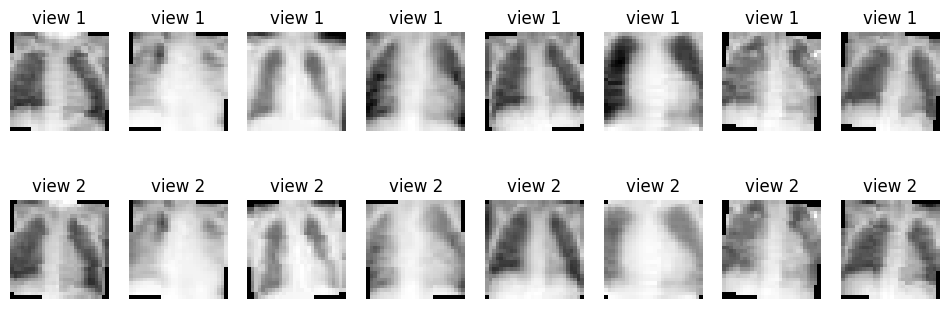

In [15]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

# Initialise data module
datamodule = SimCLRPneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
view1, view2 = batch
f, ax = plt.subplots(2, 8, figsize=(12,4))
for i in range(8):
  ax[0,i].imshow(view1[i, 0], cmap='gray')
  ax[1,i].imshow(view2[i, 0], cmap='gray')
  ax[0,i].set_title('view 1')
  ax[1,i].set_title('view 2')
  ax[0, i].axis("off")
  ax[1, i].axis("off")

## **Part B:** Implement the SimCLR loss and training step.

In this part, we ask you to:
1. Implement the SimCLR loss function, as per the equation in the lecture notes (and the [original paper](https://arxiv.org/abs/2002.05709)).
2. Once you have implemented the loss, implement the training step function in the provided LightningModule.

### **Task B-1:** SimCLR loss function.

For the implementation of the SimCLR loss, you should follow the 'recipe' from the lecture slides. We provide a code skeleton to get you started. Fill in all the blanks.

*Hint:* In PyTorch, to compute scalar products (also called dot products) between many elements efficiently, note that for two batches of $d$-dimensional feature vectors $v1$ and $v2$ of size $[N, d]$ (with $N$ being the batch size) computing the matrix multiplication `torch.mm(v1, v2.t())` returns a matrix $S$ of size $[N, N]$ where each element $S[i, j]$ is the scalar product of $v1_i$ and $v2_j$.

In [6]:
def simclr_loss(embedding_view1, embedding_view2, tau = 1.0):
  '''
  This funtion implements the SimCLR loss function as described in the original paper.
  See lecture notes for formulas.

  It takes as input the embeddings from both views and returns the loss value for that batch.
  Args:
    embedding_view1: torch tensor of shape [batch_size, embedding_dimension]
    embedding_view2: torch tensor of shape [batch_size, embedding_dimension]
  Returns:
    loss: torch.tensor of shape 1
  '''

  device = embedding_view1.device
  # Step 1: normalise the embeddings
  similarity = torch.nn.CosineSimilarity(dim=1)
  out = similarity(embedding_view1, embedding_view2)
  embedding_view1 = F.normalize(embedding_view1, dim=1)
  embedding_view2 = F.normalize(embedding_view2, dim=1)

  # Step 2: gather all embeddings into one big vector of size [2*N , feature_dim]
  z_all_views = torch.cat((embedding_view1, embedding_view2), dim=0)

  # Step 3: compute all possible similarities, should be a matrix of size [2 * N, 2 * N]
  # all_similarities[i,j] will be the similarity between z_all_views[i] and z_all_views[j].
  # Use the hint.
  all_similarities = torch.mm(z_all_views, z_all_views.t())
  all_similarities = torch.exp(all_similarities / tau)
  
  # Step 4: Here we want to return a mask of size[2 * N, 2* N] for which mask[i,j] = 1 if
  # z_all_views[i] and z_all_views[j] form a positive pair.
  # There should be exactely 2 * N non-zeros elements in this matrix.
  mask = torch.zeros(2 * embedding_view1.size(0), 2 * embedding_view1.size(0), dtype=torch.bool, device=device)
  for i in range(embedding_view1.size(0)):
    mask[i, i + embedding_view1.size(0)] = True
    mask[i + embedding_view1.size(0), i] = True

  # Step 5: self-mask. For computing the denominator term in the loss function,
  # we need to sum over all possible similarities except the self-similarity.
  # Create a mask of shape [2*N, 2*N] that is 1 for all valid pairs and 0 for all self-pairs (i = j).
  self_mask = ~torch.eye(2 * embedding_view1.size(0), dtype=torch.bool, device=device)

  # Step 6: Computing all numerators for the loss function.
  # Should be vector of size [2 * N],
  # where element is exp(sim(i, j) / t) for each positive pair (i, j).
  # Re-use the computed quantities above.
  numerators = all_similarities[mask]

  # Step 7: Computing all denominators for the loss function.
  # Should be a vector of size [2 * N].
  # Where each element should be the sum of exp(sim(i,k)/tau) for all k != i.
  
  denominators = all_similarities.masked_fill(~self_mask, 0)
  denominators = denominators.sum(dim=1)

  # Step 8: Return the final loss values, using the previously computing numerators and denominators.
  return -torch.log(numerators / denominators).mean()

#### **Check** SimCLR loss function.

To check your implementation, please run the following tests. Note that we will also use other tests on different inputs to test your code.

In [7]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

seed_everything(33)

expected_results = [torch.tensor(1.7518), torch.tensor(1.6376), torch.tensor(4.194),  torch.tensor(4.1754)]
for i, (N, feature_dim) in enumerate(zip([3, 3, 33, 33], [5, 125, 5, 125])):
  embedding_view1 = torch.rand((N, feature_dim))
  embedding_view2 = torch.rand((N, feature_dim))
  loss = simclr_loss(embedding_view1.clone(), embedding_view2.clone(), tau=0.5)
  print(f"Expected loss: {expected_results[i]}, Computed loss: {loss}")
  assert torch.isclose(loss, expected_results[i], rtol=1e-3)
print("Passed all tests successfully !")

Seed set to 33


Expected loss: 1.7517999410629272, Computed loss: 1.751814365386963
Expected loss: 1.6375999450683594, Computed loss: 1.6376436948776245
Expected loss: 4.193999767303467, Computed loss: 4.194351673126221
Expected loss: 4.1753997802734375, Computed loss: 4.17537260055542
Passed all tests successfully !


### **Task B-2:** SimCLR training step.

In this next task you are asked to complete the blanks in the provided [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

We provide the implementation of an image encoder (the CNN backbone that will act as feature extractor). No changes are needed for this part.

In [8]:
class ImageEncoder(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = models.resnet50(weights=None)
        del self.net.fc
        self.net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net.conv1(x)
        x = self.net.bn1(x)
        x = self.net.relu(x)
        x0 = self.net.maxpool(x)
        x1 = self.net.layer1(x0)
        x2 = self.net.layer2(x1)
        x3 = self.net.layer3(x2)
        x4 = self.net.layer4(x3)
        x4 = self.net.avgpool(x4)
        x4 = torch.flatten(x4, 1)
        return x4

Next, you will need to complete the implementation of the SimCLR model. In order to make the training step work correctly, you will need to implement the `process_batch` function.

In [9]:
class SimCLRModel(LightningModule):
    def __init__(self, learning_rate: float = 0.001):
        super().__init__()
        self.learning_rate = learning_rate

        self.encoder = ImageEncoder()

        self.projector = torch.nn.Sequential(
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128),
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def process_batch(self, batch):
        # TASK: Implement the process_batch function
        
        embedding_view1 = self.encoder(batch[0])
        embedding_view2 = self.encoder(batch[1])
        embedding_view1 = self.projector(embedding_view1)
        embedding_view2 = self.projector(embedding_view2)
        
        loss = simclr_loss(embedding_view1, embedding_view2)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        if batch_idx == 0:
            grid = torchvision.utils.make_grid(torch.cat((batch[0][0:4, ...], batch[1][0:4, ...]), dim=0), nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)

#### **Check** SimCLR training step.

Here you can test that your code runs fine by training the model for 5 epochs using the cell below.

Report the training and validation loss at the end of 5 epochs.

In [10]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

seed_everything(33, workers=True)

data = SimCLRPneumoniaMNISTDataModule(batch_size=32)

model = SimCLRModel()

trainer = Trainer(
    max_epochs=5,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='simclr'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | ImageEncoder | 23.5 M
1 | projector | Sequential   | 2.2 M 
-------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.925   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/kively/VSCodeProjects/Imperial_Projects/Machine_Learning_Imaging/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/Users/kively/VSCodeProjects/Imperial_Projects/Machine_Learning_Imaging/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 148/148 [02:53<00:00,  0.85it/s, v_num=1, train_loss=1.420, val_loss=3.390]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 148/148 [02:53<00:00,  0.85it/s, v_num=1, train_loss=1.420, val_loss=3.390]


## **Part C:** Linear probing and model finetuning.

In this part, you are given two different image encoders that were pre-trained with different datasets and training strategies. The objective for this task is to assess the performance of these two encoders in a downstream classification task. This this end, you are asked to implement evaluation routines seen in the lecture: linear probing and model finetuning. The downstream task is the prediction of Pneumonia in the (small) chest X-ray images from the PneumoniaMNIST dataset.

This part can be broken down into the following tasks:
1. Adapt your PneunomiaMNIST dataset for the image classification task.
2. Implement a classification model with a linear layer attached to a pre-trained image encoder.
3. For both pre-trained encoders:
    - a) Train the classifier on top of the frozen encoder (linear probing)
    - b) Finetune the entire model (including the encoder).
4. Evaluate all models on the test set, and provide a brief summary (no more than 300 words) with an analysis of your findings.

### **Task C-1:** Adapt your PneunomiaMNIST dataset for the image classification task.

We can base our implementation largely on the `SimCLRPneumoniaMNISTDataset` and adapt it to make it suitable for image classification. Think about a suitable data augmentation pipeline. Check previous tutorials for inspiration.

In [11]:
class PneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split = 'train', augmentation: bool = False):
        ''' Dataset class for Pneumonia MNST.
        The provided init function will automatically download the necessary
        files at the first class initialistion.

        :param split: 'train', 'val' or 'test', select subset

        '''
        self.flag = "pneumoniamnist"
        self.size = 28
        self.size_flag = ""
        self.root = './data/coursework/'
        self.info = INFO[self.flag]
        self.download()

        npz_file = np.load(os.path.join(self.root, "pneumoniamnist.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train','val','test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        self.do_augment = augmentation

        # TASK: Define here your data augmentation pipeline suitable for classification.
        # Check previous tutorials for inspiration.

        ########EXPLANATION:##########
        #As part of the photometric data augmentation transformations, we apply 
        #color jitter to adjust the brightness and contrast
        #with probablity 50%, hoping that the model will become more robust to 
        #lighting variations.
        #As part of the geometric data augmentation, we introduce small rotations 
        #and slight scaling. These tranformations are useful
        #for simulating variations in patient positioning and/or the distance 
        #between the X-ray source and the patient which might help
        #the model at test time. Nearest interpolation is applied to prevent any
        # unwanted smoothness in the images, as we ned to maintain
        #fine details in medical images.
    
        
        
        # photometric data augmentation
        self.photometric_augment = transforms.Compose([
            transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
        ])

        # geometric data augmentation
        self.geometric_augment = transforms.Compose([
            transforms.RandomApply(transforms=[transforms.RandomAffine(degrees=5, scale=(0.9, 1.1), interpolation=transforms.InterpolationMode.NEAREST)], p=0.5),
        ])

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        # TASK: Implement the __getitem__ function to return the image and its class label.
        image = torch.from_numpy(self.imgs[index]).unsqueeze(0)
        image = image.type(torch.FloatTensor)
        # label = torch.from_numpy(self.labels[index])
        label = self.labels[index]
        
        if self.do_augment:
            image = self.photometric_augment(image.type(torch.ByteTensor)).type(torch.FloatTensor)
            image = self.geometric_augment(image)
                        
        # normalize image intensities to [0,1] to stabilise training
        image /= 255
            
        return image, label

Again, we use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling your PneumoniaMNIST dataset. No changes needed for this part.

In [12]:
class PneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 32):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = PneumoniaMNISTDataset(split='train', augmentation=True)
        self.val_set = PneumoniaMNISTDataset(split='val', augmentation=False)
        self.test_set = PneumoniaMNISTDataset(split='test', augmentation=False)

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

#### **Check** dataset implementation.

Run the below cell to visualise a batch of your training dataloader.

Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


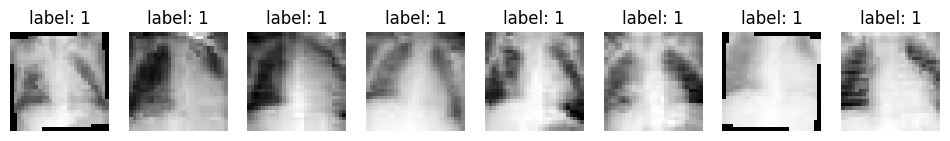

In [13]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

# Initialise data module
datamodule = PneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
images, labels = batch
f, ax = plt.subplots(1, 8, figsize=(12,4))
for i in range(8):
  ax[i].imshow(images[i, 0], cmap='gray')
  ax[i].set_title('label: ' + str(labels[i].item()))
  ax[i].axis("off")

### **Task C-2:** Implement a classification model with a linear layer attached to a pre-trained image encoder.

We first download the weights of the two pre-trained image encoders. One of them has been trained with the self-supervised SimCLR objective on a large publicly available chest X-ray dataset (different from PneunomiaMNIST). The other encoder is a standard ImageNet backbone that has been trained with a supervised classification objective on the ImageNet dataset.

In [14]:
# ! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/coursework.zip
# ! unzip coursework.zip

We provide the function for loading the encoders. No changes needed here.

In [15]:
def load_encoder_from_checkpoint(checkpoint_path):
  ckpt = torch.load(checkpoint_path, map_location='cpu')
  simclr_module = SimCLRModel()
  print(simclr_module.load_state_dict(state_dict=ckpt))
  return simclr_module.encoder.eval()

imagenet_model = './data/coursework/model_imagenet.ckpt'
chestxray_model = './data/coursework/model_chestxray.ckpt'

Now, implement a classification model as a LightningModule for image classification using a pre-trained image encoder.

The model should have a flag in the init function `freeze_encoder` that if set to true freezes all the weights in the encoder (used for linear probing), and if set to false all weights are trainable (used for model finetuning).

*Hint:* Check out previous tutorials for inspiration on how to implement a classification model as LightningModule. For the coursework, we recommend using the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) performance metric (instead of accuracy). ROC-AUC is measure of the overall discriminative power of a classification model. You can use the readily available implementation in [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html#functional-interface). You should log the ROC-AUC similar to how we logged accuracy in previous tutorials.

In [18]:
# TASK: Implement the ImageClassifier class
# Check previous tutorials for insipration how to implement an `ImageClassifier`

class ImageClassifier(LightningModule):
    def __init__(self, pretrained_encoder: torch.nn.Module, freeze_encoder: bool = True, output_dim: int = 2, learning_rate: float = 0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.output_dim = output_dim
        self.freeze_encoder = freeze_encoder
        
        self.encoder = pretrained_encoder
        if self.freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.classifier = torch.nn.Linear(2048, output_dim)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
    
    def process_batch(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y.squeeze())
        probs = torch.softmax(logits, dim=1)
        aur = auroc(probs, y.squeeze(), task="multiclass", num_classes=2)
        return loss, aur
    
    def training_step(self, batch, batch_idx):
        loss, aur = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_auroc', aur, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, aur = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_auroc', aur, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        loss, aur = self.process_batch(batch)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_auroc', aur, prog_bar=True)

### **Task C-3a:** Implement training and testing for linear probing.

Train two classification models using linear probing, one for each of the two provided image encoders. Evaluate on both the validation and test sets.

*Note:* Training for 25 epochs should be sufficient.

In [19]:
seed_everything(33, workers=True)

data = PneumoniaMNISTDataModule(batch_size=32)

# TASK: Implement the linear probing training and testing routines.

# Model 1: Linear probing with the ImageNet pre-trained encoder
model = ImageClassifier(pretrained_encoder=load_encoder_from_checkpoint(imagenet_model), freeze_encoder=True)
trainer = Trainer(
    max_epochs=25,
    accelerator='auto',
    devices=1,
    log_every_n_steps=5,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='linear_probe_imagenet'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)]
)
trainer.fit(model=model, datamodule=data)
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

# Model 2: Linear probing with the SimCLR pre-trained encoder
model = ImageClassifier(pretrained_encoder=load_encoder_from_checkpoint(chestxray_model), freeze_encoder=True)
trainer = Trainer(
    max_epochs=25,
    accelerator='auto',
    devices=1,
    log_every_n_steps=5,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='linear_probe_chestxray'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)]
)
trainer.fit(model=model, datamodule=data)
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type         | Params
--------------------------------------------
0 | encoder    | ImageEncoder | 23.5 M
1 | classifier | Linear       | 4.1 K 
--------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.023    Total estimated model params size (MB)


<All keys matched successfully>


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.
Restoring states from the checkpoint path at ./lightning_logs/coursework/linear_probe_imagenet/version_8/checkpoints/epoch=7-step=1184.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/coursework/linear_probe_imagenet/version_8/checkpoints/epoch=7-step=1184.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at ./lightning_logs/coursework/linear_probe_imagenet/version_8/checkpoints/epoch=7-step=1184.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/coursework/linear_probe_imagenet/version_8/checkpoints/epoch=7-step=1184.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_auroc           0.9082255959510803
        val_loss            0.35509124398231506
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.7919484376907349
        test_loss           0.5793928503990173
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type         | Params
--------------------------------------------
0 | encoder    | ImageEncoder | 23.5 M
1 | classifier | Linear       | 4.1 K 
--------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.023    Total estimated model params size (MB)


<All keys matched successfully>


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.
Restoring states from the checkpoint path at ./lightning_logs/coursework/linear_probe_chestxray/version_7/checkpoints/epoch=12-step=1924.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/coursework/linear_probe_chestxray/version_7/checkpoints/epoch=12-step=1924.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at ./lightning_logs/coursework/linear_probe_chestxray/version_7/checkpoints/epoch=12-step=1924.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/coursework/linear_probe_chestxray/version_7/checkpoints/epoch=12-step=1924.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_auroc           0.9339636564254761
        val_loss            0.29096561670303345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.8981112837791443
        test_loss           0.4481395184993744
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4481395184993744, 'test_auroc': 0.8981112837791443}]

### **Task C-3b:** Implement training and testing for model finetuning.

Repeat the experiments, but this time using model finetuning instead of linear probing. Evaluate on both the validation and test sets.

In [98]:
seed_everything(33, workers=True)

data = PneumoniaMNISTDataModule(batch_size=32)

# TASK: Implement the model finetuning training and testing routines.

# Model 1: Finetuning with the ImageNet pre-trained encoder
model = ImageClassifier(pretrained_encoder=load_encoder_from_checkpoint(imagenet_model), freeze_encoder=False)
trainer = Trainer(
    max_epochs=25,
    accelerator='auto',
    devices=1,
    log_every_n_steps=5,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='finetune_imagenet'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)]
)
trainer.fit(model=model, datamodule=data)
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

# Model 2: Finetuning with the SimCLR pre-trained encoder
model = ImageClassifier(pretrained_encoder=load_encoder_from_checkpoint(chestxray_model), freeze_encoder=False)
trainer = Trainer(
    max_epochs=25,
    accelerator='auto',
    devices=1,
    log_every_n_steps=5,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='finetune_chestxray'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)]
)
trainer.fit(model=model, datamodule=data)
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Seed set to 33


Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz
Using downloaded and verified file: ./data/coursework/pneumoniamnist.npz


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/coursework/finetune_imagenet

  | Name       | Type         | Params
--------------------------------------------
0 | encoder    | ImageEncoder | 23.5 M
1 | classifier | Linear       | 4.1 K 
--------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.023    Total estimated model params size (MB)


<All keys matched successfully>


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.
Restoring states from the checkpoint path at ./lightning_logs/coursework/finetune_imagenet/version_0/checkpoints/epoch=6-step=1036.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/coursework/finetune_imagenet/version_0/checkpoints/epoch=6-step=1036.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at ./lightning_logs/coursework/finetune_imagenet/version_0/checkpoints/epoch=6-step=1036.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_auroc           0.9960390329360962
        val_loss            0.07328185439109802
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Loaded model weights from the checkpoint at ./lightning_logs/coursework/finetune_imagenet/version_0/checkpoints/epoch=6-step=1036.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9606674313545227
        test_loss           0.32537344098091125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/coursework/finetune_chestxray

  | Name       | Type         | Params
--------------------------------------------
0 | encoder    | ImageEncoder | 23.5 M
1 | classifier | Linear       | 4.1 K 
--------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.023    Total estimated model params size (MB)


<All keys matched successfully>


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.
Restoring states from the checkpoint path at ./lightning_logs/coursework/finetune_chestxray/version_0/checkpoints/epoch=21-step=3256.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/coursework/finetune_chestxray/version_0/checkpoints/epoch=21-step=3256.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_auroc           0.9958899021148682
        val_loss            0.07362958043813705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at ./lightning_logs/coursework/finetune_chestxray/version_0/checkpoints/epoch=21-step=3256.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/coursework/finetune_chestxray/version_0/checkpoints/epoch=21-step=3256.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9633634686470032
        test_loss           0.46492835879325867
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.46492835879325867, 'test_auroc': 0.9633634686470032}]

### **Task C-4:** Your evaluation report.

Provide a brief summary (no more than 300 words) with an analysis of your findings. Try explaining the observed performance.


The comparison between two image encoders—SimCLR, trained on chest X-rays, and an ImageNet-trained encoder—on the PneumoniaMNIST dataset highlights the impact of domain-specific pre-training and contrastive learning. The SimCLR encoder outperforms its ImageNet counterpart (AUROC of 0.89 vs. 0.79 in linear probing reported on the test set) due to its training on a relevant domain, capturing features better suited for medical tasks like pneumonia detection. 

Contrastive learning's role in the SimCLR encoder's success underscores the value of learning discriminative features through augmentation strategies. It is worth noting that upon fine-tuning both encoders on the PneumoniaMNIST dataset, the initial performance gap narrows, with both models achieving around 0.96 AUROC. This convergence suggests that fine-tuning effectively mitigates the domain-specific advantage by allowing both models to adjust to the task at hand (i.e. pneumonia detection in chest X-ray).

The choice of AUROC as a performance metric over accuracy is particularly justified in this medical imaging context where the cost of false negatives is critical. AUROC provides a more "refined" measure of model performance, especially useful in datasets with class imbalance, offering a more reliable assessment than accuracy. Accuracy is known to be "susceptible" to predicting the majority class, whereas AUROC is better suited for medical tasks where there is often class imbalance and failing to detect a condition when it is present, might have severe consequences.

In conclusion, the initial advantage of the SimCLR encoder showcases the benefits of domain-specific pre-training and contrastive learning in medical imaging. However, the closely matched performance post-fine-tuning emphasizes the potential of both models to adapt to the task at hand. 

## Logging

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './lightning_logs/coursework/'